In [1]:
# Libraries import

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import trapezoid
from sklearn.linear_model import LinearRegression
from utilities import create_main_dataframe

In [2]:
# Functions definition

def compute_slope(x_in, y_in): # Function for computing plateau slope

    model = LinearRegression()
    model.fit(x_in, y_in)
    model.predict(x_in)

    return model.coef_[0][0]


def split_cycle_step(df): # Function for splitting measurements into cycles and steps within each cycle
    d_groups = df.groupby(["ChNum", "ConcNum"])
    processed_groups = []
    for _, group in d_groups:
        group['diff'] = group['Voltage'].diff()

        group['is_max'] = group['diff'].shift(1).gt(0) & group['diff'].lt(0)
        group['is_min'] = group['diff'].shift(1).lt(0) & group['diff'].gt(0)

        group['Cycle'] = group['is_max'].cumsum() + 1
        group['Step'] = (group['is_min'] | group['is_max']).cumsum() + 1

        group.drop(columns=['diff', 'is_max', 'is_min'], inplace=True)

        processed_groups.append(group)

    return pd.concat(processed_groups)


def compute_iv_features(df_in, v_threshold: float = -0.3, i_factor: float = 0.05, tolerance: float = 0.05, step_len: int = 50): # Function for computing I(V) curve features 

    df = df_in.copy().reset_index()

    step_val = df["Step"].unique()[0]
    cycl_val = df["Cycle"].unique()[0]
    ch_num = df["ChNum"].unique()[0]
    conc = df["OxygenC"].mean()
    conc_num = df["ConcNum"].unique()[0]

    N = df.shape[0]

    if N > step_len:

        # Compute the first drop point of the current
        med_pos = df[df['Voltage'] >= v_threshold]["Current"].median()
        abs_max = df["Current"].abs().max()

        if step_val % 2 == 0:
            fall_idx = (df["Current"] < (med_pos - i_factor * abs_max)).idxmin()
        else:
            fall_idx = (df["Current"] < (med_pos - i_factor * abs_max)).idxmax()

        i_drop = df["Current"].iloc[fall_idx]
        v_drop = df["Voltage"].iloc[fall_idx]

        # Find plateaus
        df["Diff"] = df["Current"].diff().abs()
        near_constant = (df["Diff"] < tolerance) & (df["Voltage"] < df["Voltage"].iloc[N//2])

        group_ids = near_constant.ne(near_constant.shift()).cumsum()

        plateaus = near_constant.groupby(group_ids).sum()

        max_group_id = plateaus.idxmax()
        max_plateau = near_constant[group_ids == max_group_id]

        max_segment_indices = max_plateau.index

        plateaus_len = len(max_segment_indices)
        plateaus_i = df['Current'].iloc[max_segment_indices]
        plateaus_v = df['Voltage'].iloc[max_segment_indices]

        plateaus_val = plateaus_i.median()

        plateaus_slope = compute_slope(plateaus_v.values.reshape(-1, 1), plateaus_i.values.reshape(-1, 1))

        # Find minimum between plateau mean and first drop point of the current
        idx1 = (df["Current"] - plateaus_val).abs().idxmin()
        idx2 = fall_idx
        [start, end] = np.sort([idx1, idx2])

        i_min = df["Current"].iloc[start:end].min()
        v_min_idx = (df["Current"] - i_min).abs().idxmin()
        v_min = df["Voltage"].iloc[v_min_idx]

        # Integrate the I-V curve
        integral = trapezoid(df['Current'], df['Voltage'])

        return {
            "ChNum": ch_num,
            "ConcNum": conc_num,
            "OxygenC": conc,
            "Cycle": cycl_val,
            "Step": step_val,
            "Idrop": i_drop,
            "Vdrop": v_drop,
            "Imin": i_min,
            "Vmin": v_min,
            "Pllen": plateaus_len,
            "Plval": plateaus_val,
            "Plslo": plateaus_slope,
            "Surf": integral,
            "Plidx": max_segment_indices
        }
    return None


In [3]:
# Load and prepare the data

task3_path = ".\\task_3_cv_analysis"
main_frame = create_main_dataframe(task3_path, measurement_type="test")
main_frame["OxygenC"] = main_frame["MFC2"] / (main_frame["MFC1"] + main_frame["MFC2"]) * 20.9 # Compute the Oxygen Concentration
current_data = main_frame[main_frame["DataType"] == " Current"].copy()
current_data["Current"] = current_data["Current"] * 1e3 # Current in the files is given in uA. To convert to nA values are multiplied by 1e3
current_data = split_cycle_step(current_data) # Split the 

In [4]:
# Preparation for upcoming plots 

colormap = plt.colormaps['tab10'].colors
sensors = current_data["ChNum"].unique()
categories = current_data["ConcNum"].unique()
num_categories = len(categories)

TASK 1. Visualize the CVs for each channel. Each file may contain multiple cycles.
 Propose a method to distinguish individual cycles, considering the full tri
angular potential sweep.

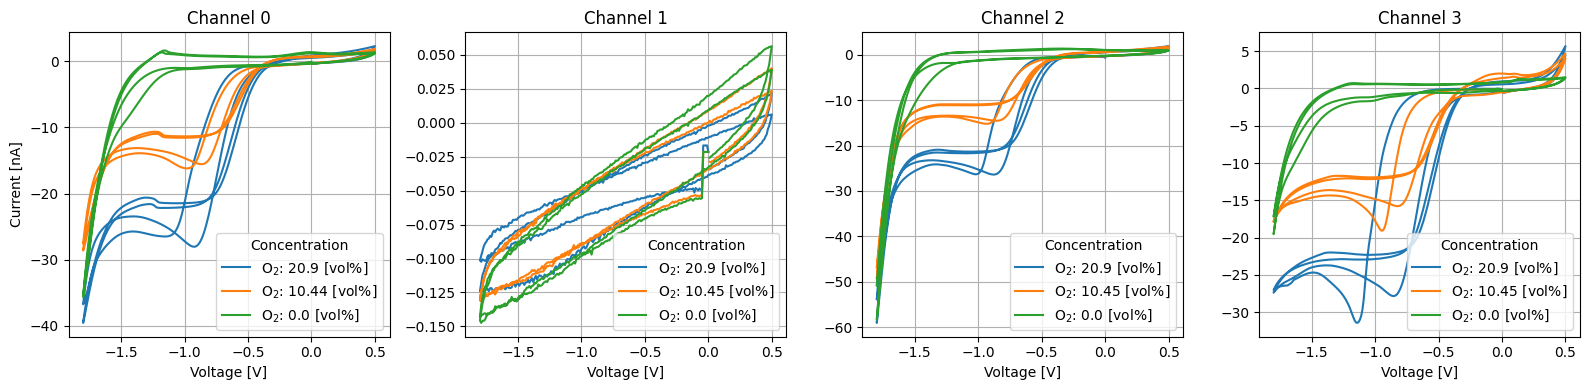

In [5]:
# Plot all I(V) measurements across all channels/sensors for all concentrations

fig0, ax0 = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

for i in range(4):
    one_sensor = current_data[(current_data["ChNum"] == sensors[i])].copy()
    one_sensor_groups = one_sensor.groupby(["ConcNum"])

    for j, (_, group) in enumerate(one_sensor_groups):
        col = colormap[j]
        label = f"O$_2$: {round(group['OxygenC'].mean(), 2)} [vol%]"

        ax0[i].plot(group["Voltage"], group["Current"], c=col, label=label)
        ax0[i].set_xlabel("Voltage [V]")
        ax0[i].grid(True)
    ax0[i].set_title(f"Channel {sensors[i]}")
    ax0[i].legend(title="Concentration", loc="lower right")

ax0[0].set_ylabel("Current [nA]")
ax0[0].set_xlabel("Voltage [V]")
fig0.tight_layout()

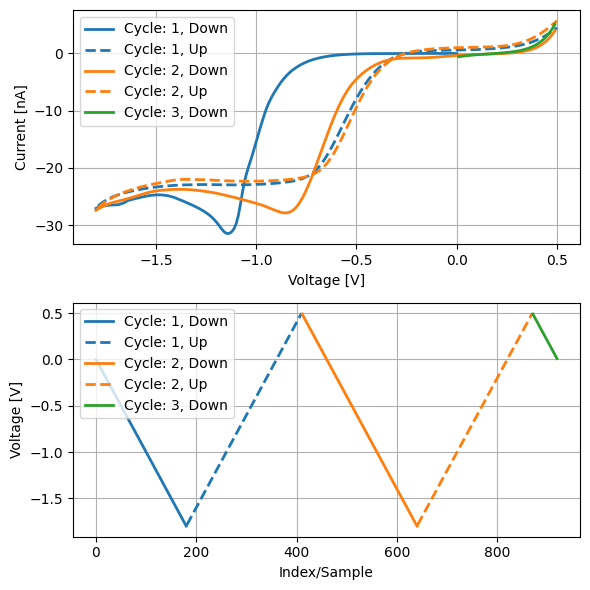

In [6]:
# Plot a single I(V) measurement to demonstrate the method for distinguishing between cycles and sweeps within a cycle

channel_number = 3
concentration_number = 0 

one_sensor_one_m = current_data[
    (current_data["ChNum"] == channel_number) &
    (current_data["ConcNum"] == concentration_number)
].copy().reset_index()


cycle_groups = one_sensor_one_m.groupby("Cycle")

fig1, ax1 = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

for i, (_, cycle_group) in enumerate(cycle_groups):
    step_groups = cycle_group.groupby("Step")
    color = colormap[i % len(colormap)]
    for j, (_, step_group) in enumerate(step_groups):
        linestyle, direction = ('-', 'Down') if j % 2 == 0 else ('--', 'Up')
        label = f"Cycle: {i + 1}, {direction}"

        ax1[0].plot(step_group["Voltage"], step_group["Current"], linewidth=2, linestyle=linestyle, color=color, label=label)
        ax1[1].plot(step_group["Voltage"], linewidth=2, linestyle=linestyle, color=color, label=label)
ax1[0].grid(True)
ax1[1].grid(True)
ax1[0].set_xlabel("Voltage [V]")
ax1[0].set_ylabel("Current [nA]")
ax1[0].legend()

ax1[1].set_xlabel("Index/Sample")
ax1[1].set_ylabel("Voltage [V]")
ax1[1].legend()

fig1.tight_layout()

TASK 2. Propose a method to summarize the curves using descriptive metrics, such
 as the width of the plateau, the potential at which the current decays, or
 any other relevant characteristics of your choice.

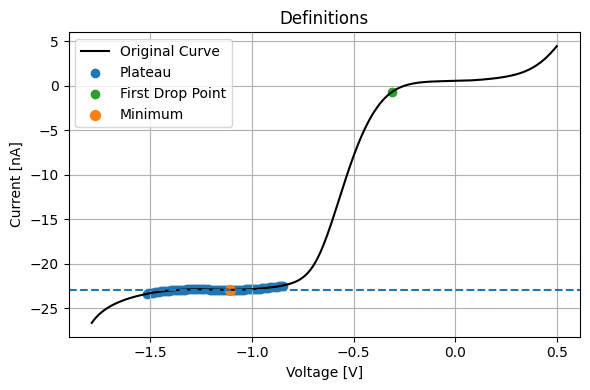

In [7]:
#Plot a single step of the I(V) measurement to define features

step = 2
one_sensor_one_step = one_sensor_one_m.groupby("Step").get_group(step).copy()
fts = compute_iv_features(one_sensor_one_step)

fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax2.plot(one_sensor_one_step['Voltage'], one_sensor_one_step['Current'], label='Original Curve', color="black")
ax2.scatter(one_sensor_one_step['Voltage'].iloc[fts["Plidx"]], one_sensor_one_step['Current'].iloc[fts["Plidx"]], color=colormap[0], label='Plateau')

ax2.axhline(fts["Plval"], color=colormap[0], linestyle="--")
ax2.scatter(fts["Vdrop"], fts["Idrop"], color=colormap[2], label='First Drop Point')
ax2.scatter(fts["Vmin"], fts["Imin"], color=colormap[1], label='Minimum', s=50)

ax2.legend()
ax2.grid(True)
ax2.set_xlabel('Voltage [V]')
ax2.set_ylabel('Current [nA]')
ax2.set_title('Definitions')
fig2.tight_layout()

In [8]:
# Compute features

fts_arr = []
one_sensor_one_step_groups = current_data.groupby(["ChNum", "ConcNum", "Step"])
for _, one_sensor_one_step in one_sensor_one_step_groups:
    fts = compute_iv_features(one_sensor_one_step)
    if fts is not None:
        fts.pop("Plidx", None)
        fts_arr.append(fts)

TASK 3. Compare the channels based on the selected metrics and discuss the results.

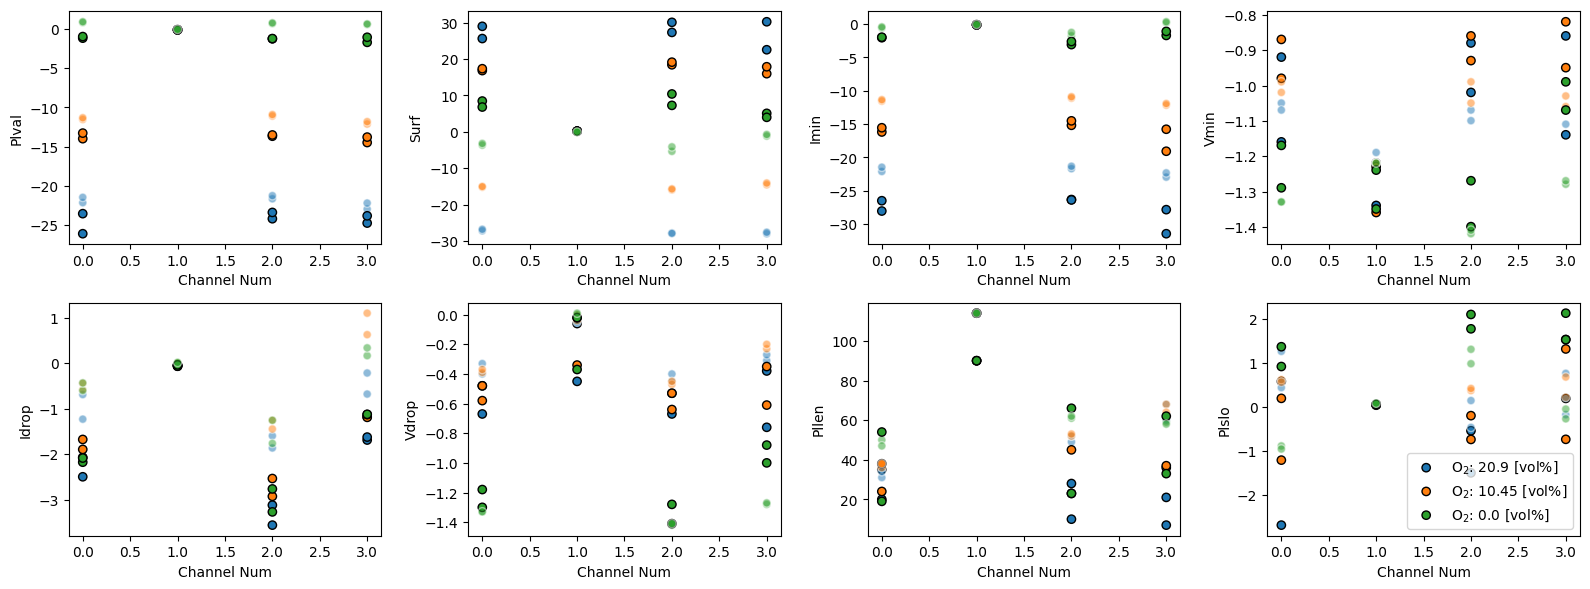

In [9]:
# Plot of the features vs. channel/sensor for all oxygen concentrations, with colors indicating concentration.
# Transparent markers (low alpha) represent upward steps in the cycle, while fully colored markers indicate downward steps

fts_arr = []

one_sensor_one_step_groups = current_data.groupby(["ChNum", "ConcNum", "Step"])

for _, one_sensor_one_step in one_sensor_one_step_groups:
    fts = compute_iv_features(one_sensor_one_step)
    if fts is not None:
        fts.pop("Plidx", None)
        fts_arr.append(fts)

features = pd.DataFrame(fts_arr)

added_legend = False
columns = ("Plval", "Surf", "Imin", "Vmin", "Idrop", "Vdrop", "Pllen",  "Plslo")

fig3, ax3 = plt.subplots(nrows=2, ncols=4, figsize=(16, 6))
for i, column in enumerate(columns):
    row, col = divmod(i, 4)
    for j in range(3):
        feat_filt = features[features["ConcNum"] == j]
        alphas = feat_filt["Step"].apply(lambda x: 0.5 if x % 2 == 0 else 1)
        edge_c = feat_filt["Step"].apply(lambda x: 'white' if x % 2 == 0 else 'black')
        label = f"O$_2$: {round(feat_filt['OxygenC'].mean(), 2)} [vol%]"
        ax3[row, col].scatter(feat_filt["ChNum"], feat_filt[column], alpha=alphas, edgecolors=edge_c, label=label)

        ax3[row, col].set_xlabel('Channel Num')
        ax3[row, col].set_ylabel(column)

plt.legend()
fig3.tight_layout()

In [10]:
# Print Features
print(features)

    ChNum  ConcNum    OxygenC  Cycle  Step     Idrop     Vdrop       Imin  \
0       0        0  20.900000      1     1 -2.499137 -0.669573 -26.495318   
1       0        0  20.900000      1     2 -1.230078 -0.399728 -22.114598   
2       0        0  20.900000      2     3 -2.070745 -0.479728 -28.044092   
3       0        0  20.900000      2     4 -0.688055 -0.329806 -21.470389   
4       0        1  10.440884      1     1 -1.895936 -0.579651 -16.190352   
5       0        1  10.440884      1     2 -0.579049 -0.389728 -11.558815   
6       0        1  10.440884      2     3 -1.676542 -0.479728 -15.552342   
7       0        1  10.440884      2     4 -0.437857 -0.369728 -11.345668   
8       0        2   0.000000      1     1 -2.177986 -1.179340  -2.054294   
9       0        2   0.000000      1     2 -0.600030 -1.329263  -0.600030   
10      0        2   0.000000      2     3 -2.087100 -1.299263  -1.973422   
11      0        2   0.000000      2     4 -0.431515 -1.329263  -0.431515   